Algorithm of SIR model
1. An array is used to represent the population in a grid lattice where 0,1 and 2 represent the Suscpetible , infected and recovered rescpetively.
2. beta and gamma are the propensity value for a single cell to cause a transmission ( infection or recovery).
In local transmission following are the steps considred
-Getting cartisian pair value of cell with value '1'.
-Getting the set of neighbours to the above list who has the value '0'. Set is considered to avoid repeatation. 
-assiging value 1 or 0 to variable 'rand1' with a probablity of beta propensity for each iteration wrt values in set(susceptible neighbours) and adding this varaible 'rand1' to the cell.Thus the randomness of transmission is wrt to the propensity value.
-same is done for the global transmission. Number of itteriation for global tranmssion is with rescpect to the number of infected cells.
3. Each infected cell is located first. Propensity value beta is used as probabilty of infecting the respective neighbouring cell or another global person.
4. Infected person are changed to recovery with the propensity value gamma with time. 
5. p value denotes the probability of local transmission. Probablity of Global transmission is calculated as (1-p).


In [ ]:

#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import random as rn
import time
from openpyxl import Workbook
import os
%matplotlib inline


In [ ]:
#Global Variables used in the simulation
#S,I,R are the counts of Susceptible , Infected and Recovered
#SI_pair is the neighbouring Susceptible and Infected which results in the local transmission of Disease
S=[]
I=[]
R=[]
t=[0]
V=[]
SI_pair=[0]
local_transmission_no=0
global_transmission_no=0
animation=0
matrices=[]
S_df=pd.DataFrame()
I_df=pd.DataFrame()
R_df=pd.DataFrame()
SI_pair_df=pd.DataFrame()
V_df=pd.DataFrame()
I_df_updated=pd.DataFrame()
Sim_statistics=pd.DataFrame()
local_infection_ratio=pd.DataFrame()
local_infection_ratio_sim=[]
peak=[]
peak_day=[]
Reproductive_No=0
beta = 0
gamma = 0
day_25=[]
day_50=[]
day_75=[]
beta_list=[]
P_values=[]
mu_values=[]
Sim_graph_flag1=0 # Assign flag value 0 if Simulation Graphs are Needed else 1 to skip 
vaccinated_nums=0
mu=0
vacc_num_list=[]
delta=0
grid_size=0
centre=[int(grid_size/2),int(grid_size/2)]
radius=[int(grid_size/2),int(grid_size/2)]
dist_from_centre=[]
control_pop=[]
global_flag=0
radius_list=[]

#Defining the functions

In [ ]:
#test matrix
#cell with 0 is Susceptible
#cell with 1 is infected
#cell with 2 is recovered
#Intializing the infection in the grid by assigning 1,
def matrix_init():
    mtx=np.zeros((grid_size,grid_size))
    a=[1,6,7,8]
    b=[1,4,5,6]
    mtx[a,b]=1
    pop_stat(S,I,R,V,mtx)
    SI_pair.append(len(SI_neighbour(mtx)))

    return mtx


In [ ]:
def rand_initial_loc():
    # mtx=[]
    # mtx=np.zeros((grid_size,grid_size))
    rand_a=rn.sample(range(grid_size),4)
    rand_b=rn.sample(range(grid_size),4)
    # mtx[rand_a,rand_b]=1
    # print('intiatied')
    return (rand_a,rand_b)
    

In [ ]:
#getting the status count of population at a time step
def pop_stat(sus,inf,rec,vac,mtx):
    sus.append(mtx[np.where(mtx==0)].size)
    inf.append(mtx[np.where(mtx==1)].size)
    rec.append(mtx[np.where(mtx==2)].size)
    vac.append(vac[-1]+count)

In [ ]:

def circular_mask(grid_size,centre,radius):

    if centre is None:
        centre=[5,5]
    if radius is None:
        radius=(1)
    # print(radius)
    Y,X = np.ogrid[:grid_size,:grid_size]
    dist_from_centre= np.sqrt((X - centre[0])**2 + (Y- centre[1])**2)
    mask=dist_from_centre <= radius


    return mask

In [ ]:

def global_cirucular_sus(grid_size,centre,radius,mtx):
    global control_pop
    control_pop=[]
    mask=circular_mask(grid_size,centre,radius)
    # print(mask)
    idx = np.where(mask)
    # print(idx)
    for (i,j) in zip(idx[0],idx[1]):
        if mtx[i,j]==0:
           control_pop.append(tuple([i,j]))
    return control_pop


In [ ]:
#Acquires the location of the neighbouring suscpetible to the infected in a time step. Gives the list of cartesian pair of the Suscptibles.
#Neighbours are considered in the vertical and horizontal directions. Diagonals are avoided.
def SI_neighbour(mtx):
    index_x=[]
    index_y=[]
    index_x,index_y, =np.where(mtx==1)
    neigh_loc=set()
    for (i,j) in zip(index_x,index_y):
        #print(i,j)
        if i+1 <grid_size:
            if mtx[[i+1],[j]] == 0:
                neigh_loc.add(tuple(([i+1,j])))
        if i-1 > -1:
            if mtx[[i-1],[j]] == 0:
                neigh_loc.add(tuple(([i-1,j])))
        if j+1 <grid_size:
            if mtx[[i],[j+1]] == 0:
                neigh_loc.add(tuple(([i,j+1])))
        if j-1 >-1:
            if mtx[[i],[j-1]] == 0:
                neigh_loc.add(tuple(([i,j-1])))            
    return neigh_loc

In [ ]:
#infected people are changed to recovred with the probability of the gamma value.
def recovering(mtx,gamma):
    recover_index_x,recover_index_y,= np.where(mtx==1)
    for (i,j) in zip (recover_index_x,recover_index_y):
        rand1=rn.choices([1,0],weights= [gamma,1-gamma],k=1)
        mtx[i,j]=mtx[i,j]+rand1

In [ ]:
#infecting the neighbouring susceptible cells with a probablity of beta
#1 infected person has possibilty to infect another one susceptible in a time step.
#  A susceptible is chosen at random from the respective suscptible list
def local_infection(mtx,beta):
    SI_locs= SI_neighbour(mtx)
    for i in range (I[-1]):
        randneigh=[]
        if len(SI_locs) == 0:
            continue
        randneigh=rn.choices(tuple(SI_locs))
        rand1=rn.choices([1,0],weights= [beta,1-beta],k=1)
        if mtx[randneigh[0][0],randneigh[0][1]]==0:
            mtx[randneigh[0][0],randneigh[0][1]]=mtx[randneigh[0][0],randneigh[0][1]]+rand1    

In [ ]:
#Suceptibles are infected in global level
#Number of global suscptible considered in a time step is same as the number of SI pair so that a tally is kept between the local and global.
#1 infected person has possibilty to infect another one susceptible in a time step.
#  A susceptible is chosen at random from the respective suscptible list
def global_infection(mtx,beta):
    global_pop=set()
    index_x,index_y, =np.where(mtx==0) 
    for (i,j) in zip(index_x,index_y):
        global_pop.add(tuple(list([i,j])))
    
    
    for i in range (len(global_pop)):
        if len(global_pop) == 0:
            continue
        randneigh=[]
        randneigh=rn.choices(tuple(global_pop))
        rand1=rn.choices([1,0],weights=[beta,1-beta],k=1)
        if mtx[randneigh[0][0],randneigh[0][1]]==0:
            mtx[randneigh[0][0],randneigh[0][1]]=mtx[randneigh[0][0],randneigh[0][1]]+rand1

In [ ]:
#Suceptibles are infected in global level
#Number of global suscptible considered in a time step is same as the number of SI pair so that a tally is kept between the local and global.
#1 infected person has possibilty to infect another one susceptible in a time step.
#  A susceptible is chosen at random from the respective suscptible list
def controlled_global_infection(mtx,beta,radius):
    global_inf_pop=set()
    index_x,index_y, =np.where(mtx==1) 
    for (i,j) in zip(index_x,index_y):
        global_inf_pop.add(tuple(list([i,j])))        
    for i in range (len(global_inf_pop)):
        if len(global_inf_pop)==0:
            continue
        randinf=[]
        randinf=rn.choices(tuple(global_inf_pop))
        # print(randinf[0])
        global_cirucular_sus(grid_size,(randinf[0][0],randinf[0][1]),radius,mtx)
        
        for i in range (len(control_pop)):
            if len(control_pop) == 0:
                continue
            randcontsus=[]
            randcontsus=rn.choices(tuple(control_pop))
            rand1=rn.choices([1,0],weights=[beta,1-beta],k=1)
            if mtx[randcontsus[0][0],randcontsus[0][1]]==0:
                mtx[randcontsus[0][0],randcontsus[0][1]]=mtx[randcontsus[0][0],randcontsus[0][1]]+rand1
        # print(control_pop)


In [ ]:
#Vaccination of SIR model
#Both suceptible and infected is subjected to vaccination. 
#In a time step a Certain number of people (vacc_per_day)is subjected to dose. 
#This dose also given a percentage of effectiveness (mu)

def vaccination(mtx,number):
    global count
    count=0
    unvaccinated_loc=[]
    rand1=0
    vaccination_index_x,vaccination_index_y,= np.where((mtx == 1) | (mtx==0))
    unvaccinated_loc=list(zip(vaccination_index_x,vaccination_index_y))
    for i in range(number):    
        if len(unvaccinated_loc) == 0:
            break
        randunvaccinated=[]
        # print(unvaccinated_loc)
        randunvaccinated=rn.choices(unvaccinated_loc)
        rand1=rn.choices([1,0],weights= [mu,1-mu],k=1)
        if rand1[0]==1:
            mtx [randunvaccinated[0][0],randunvaccinated[0][1]]=2
            count=count+1   
    

In [ ]:
#Graph ploting funciton
#Median is used to represent the simulation in general.
#The IQR for infected is plotted as box

def graph_plot_SIR(s,i,r,si,v):
    fig, axs1 = plt.subplots()
    ts=list(range(1,len(s)+1))
    ti=list(range(1,len(i)+1))
    tr=list(range(1,len(r)+1))
    tsi=list(range(1,len(si)+1))
    tv=list(range(1,len(v)+1))
    axs1.plot(ts,s,label = 'Susecptible')
    axs1.plot(ti,i,label = 'Infected')
    axs1.plot(tr,r,label = 'Recovered')
    # axs12=axs1.twinx()
    # axs12.plot(tv,v,label = 'Vaccinated',color='red')
    # axs12.legend(loc=1)
    axs1.plot(tv,v,label = 'Vaccinated',color='red')
    axs1.plot([],[],' ',label ='Last Recovered Day:%.0f'%req_ind[0])
    axs1.plot([],[],' ',label ='No of Vaccinated:%.0f'%((V_df['V_Median'].tail(1))))
    # axs2.plot(tsi,si,label = 'SI Pair')
    I_df_updated.T.boxplot(ax=axs1,grid=False,showfliers=False,whis=0,color='orange',patch_artist=True,boxprops={'alpha':0.5,'facecolor':'orange'})
    axs1.legend(loc=1)
    axs1.set_title('SIR Vacc/day=%.1f mu %0.2f'%(vacc_per_day,mu) )
    # axs2.set_title('SI pair p=%.1f $R_{o}$:%0.2f'%(p,Reproductive_No))
    axs1.set_ylabel('Population')
    axs1.set_xlabel('Days')
    # axs2.set_xlabel('Days')
    axs1.xaxis.set_major_locator(plt.MaxNLocator())
    # axs1.annotate('Peak Infected No %.2f '%peak,xy=(peak_day+20,peak+20),xytext=(grid_size,grid_size))
    axs1.plot([peak_day[-1]+1],[peak[-1]],'o')
    axs1.annotate('Day of the peak:%.0f\nPeak Infected No:%.0f  '%(peak_day[-1] ,peak[-1]),xy=(peak_day[-1]+1,peak[-1]))
    os.makedirs('SIR_Sim',exist_ok=True)
    plt.savefig(os.path.join('SIR_SIM','vd%.1f_mu%.1f.pdf'%(vacc_per_day,mu)))
    plt.xlabel('Days')
    plt.show()


In [ ]:
#Graph ploting funciton
#Median is used to represent the simulation in general.
#The IQR for infected is plotted as box

def graph_plot_SIR_Radius(s,i,r,si,v):
    fig, axs1 = plt.subplots()
    ts=list(range(1,len(s)+1))
    ti=list(range(1,len(i)+1))
    tr=list(range(1,len(r)+1))
    tsi=list(range(1,len(si)+1))
    tv=list(range(1,len(v)+1))
    axs1.plot(ts,s,label = 'Susecptible')
    axs1.plot(ti,i,label = 'Infected')
    axs1.plot(tr,r,label = 'Recovered')
    # axs12=axs1.twinx()
    # axs12.plot(tv,v,label = 'Vaccinated',color='red')
    # axs12.legend(loc=1)
    # axs1.plot(tv,v,label = 'Vaccinated',color='red')
    axs1.plot([],[],' ',label ='Last Recovered Day:%.0f'%req_ind[0])
    axs1.plot([],[],' ',label ='Beta:%.1f'%((beta)))
    # axs2.plot(tsi,si,label = 'SI Pair')
    I_df_updated.T.boxplot(ax=axs1,grid=False,showfliers=False,whis=0,color='orange',patch_artist=True,boxprops={'alpha':0.5,'facecolor':'orange'})
    axs1.legend(loc=1)
    axs1.set_title('SIR Controlled Global Radius=%.1f '%(radius) )
    # axs2.set_title('SI pair p=%.1f $R_{o}$:%0.2f'%(p,Reproductive_No))
    axs1.set_ylabel('Population')
    axs1.set_xlabel('Days')
    # axs2.set_xlabel('Days')
    axs1.xaxis.set_major_locator(plt.MaxNLocator())
    # axs1.annotate('Peak Infected No %.2f '%peak,xy=(peak_day+20,peak+20),xytext=(grid_size,grid_size))
    axs1.plot([peak_day[-1]+1],[peak[-1]],'o')
    axs1.annotate('Day of the peak:%.0f\nPeak Infected No:%.0f  '%(peak_day[-1] ,peak[-1]),xy=(peak_day[-1]+1,peak[-1]))
    os.makedirs('SIR_Sim',exist_ok=True)
    plt.savefig(os.path.join('SIR_SIM','radius%.1f_beta%.1f.pdf'%(radius,beta)))
    plt.xlabel('Days')
    plt.show()


In [ ]:
# Simulating the for one time 
# The values of S,I,R are stored in a pandas data frame.
def simulation(j):
    global S
    global I
    global R
    global V
    global SI_pair
    global global_transmission_no
    global local_transmission_no
    global local_infection_ratio_sim
    global p
    global count
    S=[]
    I=[]
    R=[]
    V=[0]
    count = 0
    SI_pair=[]
    # matx= matrix_init()
    matx=np.zeros((grid_size,grid_size))
    matx[x_loc,y_loc]=1

    global_transmission_no =0
    local_transmission_no=0
    for i in range(tend):
        prop=rn.uniform(0, 1)
        if prop <=p:
            local_infection(matx,beta)    
            local_transmission_no = local_transmission_no + 1
        prop=rn.uniform(0, 1)
        if prop>=p:    
            if global_flag==0: 
                global_infection(matx,beta)
            else:
                controlled_global_infection(matx,beta,radius)    
            global_transmission_no=global_transmission_no + 1
        SI_pair.append(len(SI_neighbour(matx)))
        vaccination(matx,vacc_per_day)
        recovering(matx,gamma)
        pop_stat(S,I,R,V,matx)
    S_df[j]=S
    I_df[j]=I
    R_df[j]=R
    V_df[j]=V
    SI_pair_df[j]=SI_pair
    local_infection_ratio_sim.append(local_transmission_no/(local_transmission_no+global_transmission_no))
    


def animi(i):    
    ax.clear()
    im = ax.imshow(matrices[:,:,i])
anim = ani.FuncAnimation(fig, animi,frames=tend,  interval=1000, blit=False)
from IPython.display import HTML
HTML(anim.to_jshtml())
anim.save('save.gif',dpi=80, writer='imagemagick')

In [ ]:
#Running the same simulation number of time to find the average behaviour of the simulation.

def sim_replication(n,Sim_graph_flag1):
    #Performning the simulation and generating the data base
    global I_df_updated
    global req_ind
    global peak
    global peak_day
    global radius_list
    global matx
    global x_loc
    global y_loc
    x_loc,y_loc= rand_initial_loc()
    for j in range (num_sim):
        simulation(j)
    # Finding the mean values for each repeated simulation step 
    req_ind=[]  
    S_df['S_Median']=S_df.median(axis=1)
    I_df['I_Median']=I_df.median(axis=1)
    R_df['R_Median']=R_df.median(axis=1)
    V_df['V_Median']=V_df.median(axis=1)
    SI_pair_df['SI_Median']=SI_pair_df.median(axis=1)
    day_50.append(S_df['S_Median'].sub((grid_size*grid_size)/2).abs().idxmin())
    day_25.append(S_df['S_Median'].sub((grid_size*grid_size)*3/4).abs().idxmin())
    day_75.append(S_df['S_Median'].sub((grid_size*grid_size)/4).abs().idxmin())
    peak.append(max(I_df['I_Median']))
    radius_list.append(radius)
    beta_list.append(beta)
    peak_day.append(I_df.index[I_df['I_Median']==max(I_df['I_Median'])][0] )
    req_ind=R_df.index[R_df['R_Median']==max(R_df['R_Median'])] 
    I_df_updated=I_df.head(req_ind[0]+1)   
    if Sim_graph_flag1==0:
        graph_plot_SIR_Radius(S_df.iloc[:req_ind[0]+1,-1],I_df.iloc[:req_ind[0]+1,-1],R_df.iloc[:req_ind[0]+1,-1],SI_pair_df.iloc[:req_ind[0]+1,-1],V_df.iloc[:req_ind[0]+2,-1])

Defining the function to iterate the required parameters. 

In [ ]:
#Running the whole simulatin for increasing p value
def iter_infection_p():
    global p    	
    global P_values
    p=0
    for n in range(11):
        sim_replication(n,Sim_graph_flag1)  
        P_values.append(p)
        p=p+0.1
        beta_list.append(beta)

In [ ]:
#Running the whole simulatin for increasing p value
def iter_vacc_eff_mu():
    global mu
    global mu_values
    global radius
    mu=.50
    for n in range(5):
        sim_replication(n,Sim_graph_flag1)  
        mu_values.append(mu)
        mu=mu+0.1
        vacc_num_list.append(vacc_per_day)

In [ ]:
#Running the whole simulatin for increasing p value
def iter_initil_matrix():
    # global mu
    # global mu_values
    global radius
    # mu=.50
    radius=2
    for n in range(20):
        sim_replication(n,Sim_graph_flag1)  
        # radius=radius+1
        # vacc_num_list.append(vacc_per_day)

In [ ]:
#Iterating vaccination number value 5,10,15,20
#Plotting the Simulation statistics
# ax=Sim_statistics.groupby('Beta_value')['Day of 50per infected'].plot(legend=True,title='P vs 50% Infected',ylabel='Days',grid=True)



def vacc_iteration(q):
    global mu
    global vacc_per_day
    for q in range (q):
        # Reproductive_No=beta/gamma
        iter_radius()
        vacc_per_day=vacc_per_day+5
    Sim_statistics['Peak Infection']=peak
    Sim_statistics['Day of Peak Infection']=peak_day
    Sim_statistics['Day of 50per infected']=day_50
    Sim_statistics['Day of 25per infected']=day_25
    Sim_statistics['Day of 75per infected']=day_75
    Sim_statistics['Num_of_vacc']=vacc_num_list
    Sim_statistics['Efficiency']=mu_values
    Sim_statistics.set_index('Efficiency',inplace=True)
    ax=Sim_statistics.groupby('Num_of_vacc')['Day of 50per infected'].plot(legend=True,title='P vs 50% Infected',ylabel='Days',grid=True)
    plt.legend(['0.1','0.3','0.5','0.7','0.9'],title='Beta')
    # Sim_statistics.set_index('Beta_value',append=True).swaplevel(0).to_excel('output.xlsx')


In [ ]:
#Iterating radius of infection 0
#Plotting the Simulation statistics
# ax=Sim_statistics.groupby('Beta_value')['Day of 50per infected'].plot(legend=True,title='P vs 50% Infected',ylabel='Days',grid=True)



def radius_iteration(q):
    global radius
    for q in range (q):
        # Reproductive_No=beta/gamma
        radius = 2
        iter_radius()
        beta=beta+0.1
    Sim_statistics['Peak Infection']=peak
    Sim_statistics['Day of Peak Infection']=peak_day
    Sim_statistics['Day of 50per infected']=day_50
    Sim_statistics['Day of 25per infected']=day_25
    Sim_statistics['Day of 75per infected']=day_75
    # ax=Sim_statistics.groupby('Num_of_vacc')['Day of 50per infected'].plot(legend=True,title='P vs 50% Infected',ylabel='Days',grid=True)
    # Sim_statistics['Num_of_vacc']=vacc_num_list
    # Sim_statistics['Efficiency']=mu_values
    # Sim_statistics.set_index('Efficiency',inplace=True)
    # plt.legend(['0.1','0.3','0.5','0.7','0.9'],title='Beta')
    # Sim_statistics.set_index('Beta_value',append=True).swaplevel(0).to_excel('output.xlsx')


Stocastic Simulation of SIR model

In [ ]:
#Iterating Beta value 0.1 to 0.9
#Plotting the Simulation statistics
# ax=Sim_statistics.groupby('Beta_value')['Day of 50per infected'].plot(legend=True,title='P vs 50% Infected',ylabel='Days',grid=True)



def Beta_iteration(q):
    global beta
    global Reproductive_No
    for q in range (q):
        Reproductive_No=beta/gamma
        radius = 2
        iter_initil_matrix()
        # iter_infection_p()
        beta=beta+0.1
    Sim_statistics['Peak Infection']=peak
    Sim_statistics['Day of Peak Infection']=peak_day
    Sim_statistics['Day of 50per infected']=day_50
    Sim_statistics['Day of 25per infected']=day_25
    Sim_statistics['Day of 75per infected']=day_75
    Sim_statistics['Beta_value']=beta_list
    Sim_statistics['Radius']=radius_list
    # Sim_statistics['P_values']=P_values
    # Sim_statistics.set_index('P_values',inplace=True)
    Sim_statistics.set_index('Radius',inplace=True)
    # ax=Sim_statistics.groupby('Beta_value')['Day of 50per infected'].plot(legend=True,title='Radius vs 50% Infected',ylabel='Days',grid=True)
    # plt.legend(['0.1','0.3','0.5','0.7','0.9'],title='Beta')
    # Sim_statistics.set_index('Beta_value',append=True).swaplevel(0).to_excel('output_vacc%.1f_eff%.1f.xlsx'%(NUMBER,mu))


In [ ]:
# defining Constants used
#beta is the Infection rate constant
#gamma is the recovering constant
#tend is the number of time steps
#total population is (grid size^2)
#p is proportion for global and local transmission( local:global = p:1-p )

gamma = 0.1
beta = 0.3
tend=150
grid_size=10
p=0
radius=2
num_sim=10
Sim_graph_flag1=1 # Assign flag value 0 if Simulation Graphs are Needed else 1 to skip 
vacc_per_day=0 #number of people needs to vaccinated in a day of the simulaiton
mu=0.90#effectiveness of the vaccination on the people
num_beta_iteration=5
global_flag=1


In [89]:
Beta_iteration(1)

Standard Deviation of Peak Day = 2.028741


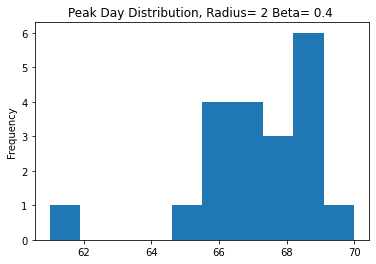

In [90]:
Sim_statistics['Peak Infection'].plot(kind='hist',title='Peak Day Distribution, Radius= %.0f Beta= %.1f '%(radius,beta)) 
print('Standard Deviation of Peak Day = %f' %Sim_statistics['Peak Infection'].std())